# aim:

check custom student-t lines up with one from scipy
plot pdf for 1d at mean, does it go above 0 ?


In [1]:
# init things
from sklearn.cluster import KMeans
from scipy.stats import wishart, dirichlet, invwishart, multivariate_normal, beta, multivariate_t, multinomial
from sklearn.metrics.cluster import adjusted_rand_score as ari
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky
import numpy as np
import plot_hmm
import numba_functions
from numpy.random import binomial
import matplotlib.pyplot as plt
from scipy.special import gammaln

In [17]:

def _multivariate_students_t(x, mu, shape, v, D):
    """
    Return the value of the log multivariate Student's t PDF at `X[i]`.
    """
    delta = x - mu
    v = int(v)

    logdet_covar = np.linalg.slogdet(shape)[1]
    inv_covar = np.linalg.inv(shape)

    return gammaln((v + D) / 2) - gammaln((v) / 2) - D/2.*np.log(v) - D/2.*np.log(np.pi) - logdet_covar/2 - \
         (v + D)/2. * np.log(1 + 1./v * np.dot(np.dot(delta, inv_covar), delta))

def student_t_giw(x, mt, kt, nut, St, D):
    loc = mt
    shape = St * (kt + 1.)/(kt*(nut - D + 1.))
    df = (nut - D + 1.)
    return _multivariate_students_t(x, loc, shape, df, D)

def scipy_t_wrapper(x, mt, kt, nut, St, D):
    loc = mt
    shape = St * (kt + 1.)/(kt*(nut - D + 1.))
    df = (nut - D + 1.)
    return multivariate_t.logpdf(x, loc, shape, df)


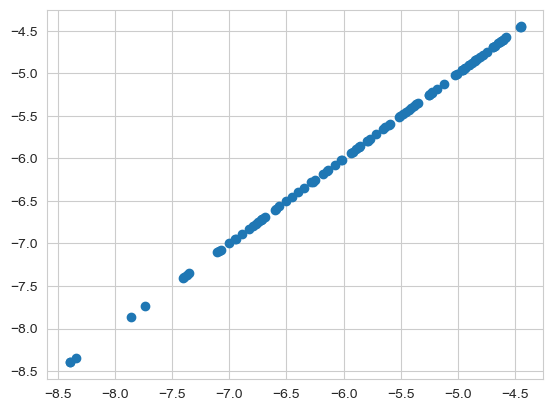

In [20]:
m0 = np.array([-10, 20])
k0 = 1   # how much we believe m0
nu0 = 4 # since nu0 + 2 will mean <sigma> = S0
S0 = np.array([[20,0],[0,20]])
D = 2
N = 100

samples = multivariate_normal.rvs(m0, S0, N)
# plt.scatter(samples[:,0], samples[:, 1])

pdfs = np.zeros((N, 2))
for i in range(N):
    pdfs[i, ] = scipy_t_wrapper(samples[i], m0, k0, nu0, S0, D), student_t_giw(samples[i], m0, k0, nu0, S0, D)

plt.scatter(pdfs[:,0], pdfs[:, 1])

In [25]:
def is_symmetric_positive_semidefinite(matrix):
    # Check for symmetry
    if not (matrix == matrix.T).all():
        return False

    # Check for positive semidefiniteness
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

# now get values which are causing issues:
xn = np.array([9.28876729, -4.62840729])
Sn = np.array([[-1192.42599079, 646.43170256], [646.43170256, -186.08818082]])
mn = np.array([2.67748355, -1.06180212])
kn = 210
nun = 204

# is_symmetric_positive_semidefinite(S0)


Sn.T

# # student_t_giw(xn, mn, kn, nun, Sn, D)
# scipy_t_wrapper(xn, mn, kn, nun, Sn, D)

array([[-1192.42599079,   646.43170256],
       [  646.43170256,  -186.08818082]])

In [27]:
def ensure_symmetric_positive_semidefinite(A):
    # Ensure symmetry
    A = (A + A.T) / 2.0

    # Ensure positive semidefiniteness
    eigvals, eigvecs = np.linalg.eigh(A)
    eigvals[eigvals < 0] = 0
    A = eigvecs @ np.diag(eigvals) @ eigvecs.T

    return A

# Example usage
S = np.array([[2, 1], [1, 3]])
updated_S = ensure_symmetric_positive_semidefinite(Sn)

print("Original Matrix:")
print(Sn)
print("\nUpdated Matrix (Symmetric Positive Semidefinite):")
print(updated_S)

Original Matrix:
[[-1192.42599079   646.43170256]
 [  646.43170256  -186.08818082]]

Updated Matrix (Symmetric Positive Semidefinite):
[[ 25.05942686  51.26181152]
 [ 51.26181152 104.86166882]]
